### Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Функции для оптимизации

In [2]:
def reduction_memory(df: pd.DataFrame):
    """function for reduction memory size"""
    
    df_c = df.copy()
    
    for column in df_c.columns:
    
        series = df_c[column]
        
        if series.dtype == 'float64':
            if (series != series.astype('float32')).sum() == 0:
                df_c[column] = series.astype('float32')
        elif series.dtype == 'int64':
            if (series != series.astype('int8')).sum() == 0:
                df_c[column] = series.astype('int8')
            elif (series != series.astype('int16')).sum() == 0:
                df_c[column] = series.astype('int16')
            elif (series != series.astype('int32')).sum() == 0:
                df_c[column] = series.astype('int32')
                
    return df_c

## 1. Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

In [3]:
df_pjme_mw = pd.read_csv('../input/lesson2-time-series/my_PJME_MW.csv', index_col=0, parse_dates=['Date'])
df_pjme_mw = reduction_memory(df_pjme_mw)
df_pjme_mw[:2]

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0


In [4]:
df_pjme_mw_month = df_pjme_mw.resample(rule='M').mean()
df_pjme_mw_month[:2]

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-31,31075.400391,2002.0,1.0,16.020188,1.0,16.020188,2.873486,2.905787,11.515478,0.063257,0.032301,0.064603
2002-02-28,30239.166016,2002.0,2.0,14.500000,1.0,45.500000,7.071429,3.000000,11.500000,0.035714,0.035714,0.035714


## 2. Подберите параметры модели SARIMAX для этого ряда.

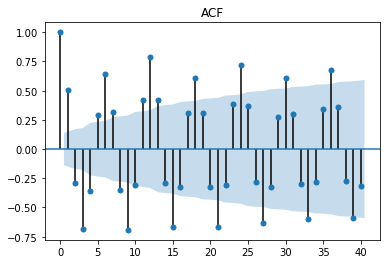

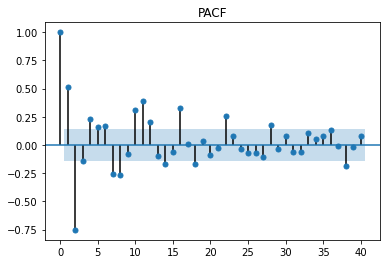

In [5]:
#ACF
sm.graphics.tsa.plot_acf(df_pjme_mw_month['PJME_MW'].values, lags=40, title='ACF')
plt.show()
#PACF
sm.graphics.tsa.plot_pacf(df_pjme_mw_month['PJME_MW'].values, lags=40, title='PACF')
plt.show()

                                      SARIMAX Results                                      
Dep. Variable:                             PJME_MW   No. Observations:                  200
Model:             SARIMAX(0, 0, 1)x(5, 2, [], 12)   Log Likelihood               -1037.230
Date:                             Fri, 06 Nov 2020   AIC                           2088.460
Time:                                     12:00:43   BIC                           2107.735
Sample:                                 01-31-2002   HQIC                          2096.285
                                      - 08-31-2018                                         
Covariance Type:                               opg                                         
=========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------

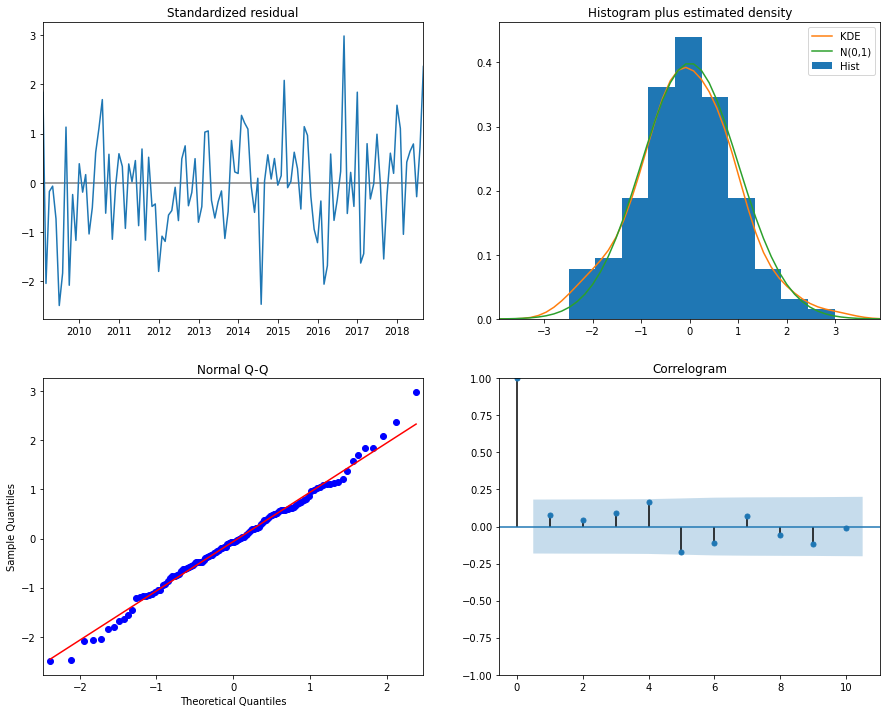

In [6]:
mod_sarimax = sm.tsa.statespace.SARIMAX(df_pjme_mw_month['PJME_MW'], order=[0, 0, 1], 
                                        seasonal_order=[5, 2, 0, 12],
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)
result = mod_sarimax.fit()
print(result.summary().tables[0], result.summary().tables[1])

result.plot_diagnostics(figsize=(15, 12))
plt.show()

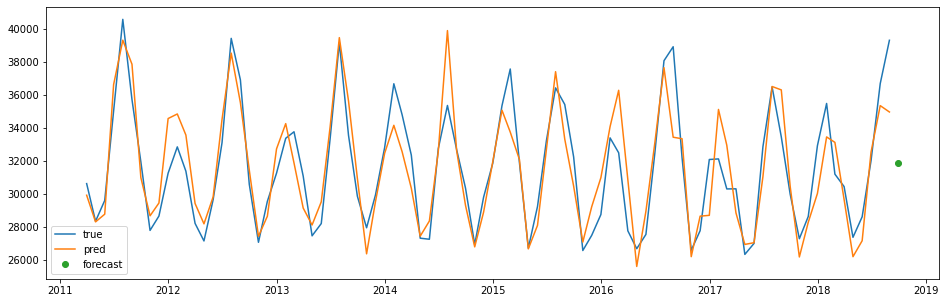

In [7]:
N = 90
plt.figure(figsize=(16,5))
plt.plot(df_pjme_mw_month['PJME_MW'][-N:], label='true')
plt.plot(result.predict()[-N:], label='pred')
plt.plot(result.forecast(), 'o', label='forecast')

plt.legend()
plt.show()

## 3. Сделайте вывод о том, как изменилась модель по сравнению с недельной.

In [8]:
df_pjme_mw_week = df_pjme_mw.resample(rule='W').mean()
df_pjme_mw_week[:2]

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-06,32392.160156,2002.0,1.0,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,0.0,0.167832
2002-01-13,31487.386719,2002.0,1.0,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,0.0,0.000000


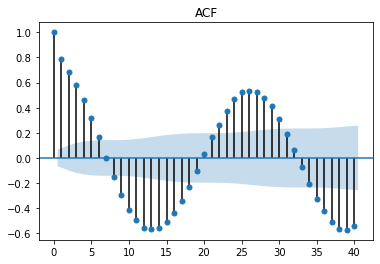

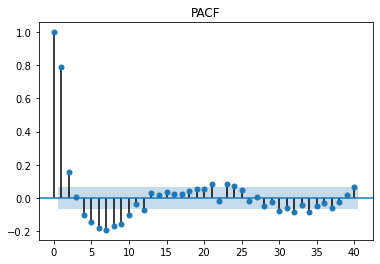

In [9]:
#ACF
sm.graphics.tsa.plot_acf(df_pjme_mw_week['PJME_MW'].values, lags=40, title='ACF')
plt.show()
#PACF
sm.graphics.tsa.plot_pacf(df_pjme_mw_week['PJME_MW'].values, lags=40, title='PACF')
plt.show()

                                     SARIMAX Results                                      
Dep. Variable:                            PJME_MW   No. Observations:                  200
Model:             SARIMAX(1, 0, 0)x(3, 1, 0, 13)   Log Likelihood               -1363.947
Date:                            Fri, 06 Nov 2020   AIC                           2737.894
Time:                                    12:00:51   BIC                           2752.847
Sample:                                10-12-2014   HQIC                          2743.970
                                     - 08-05-2018                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

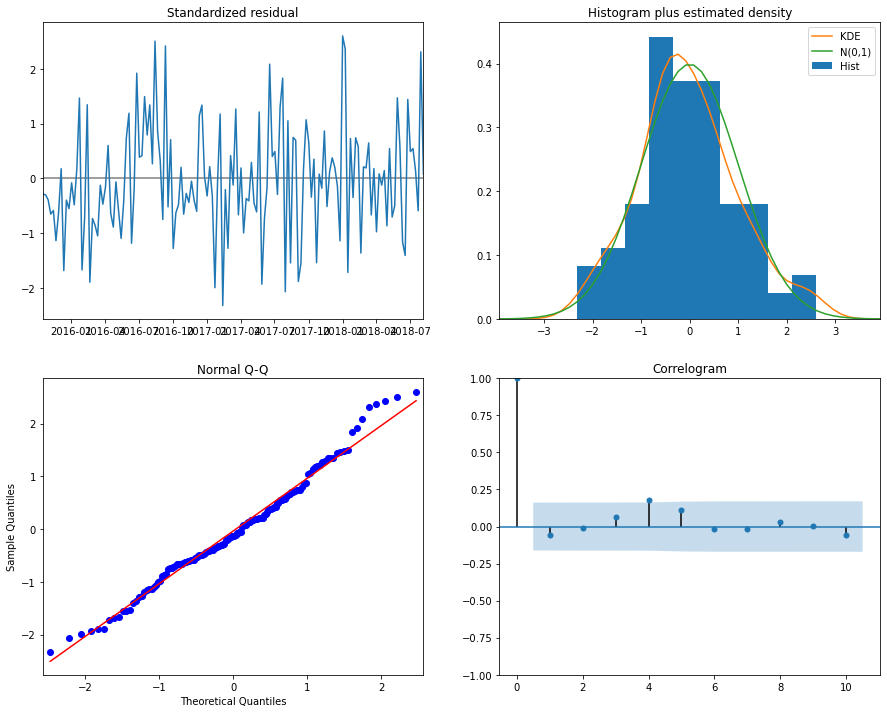

In [10]:
mod_sarimax = sm.tsa.statespace.SARIMAX(df_pjme_mw_week['PJME_MW'][-200:], order=[1, 0, 0], 
                                        seasonal_order=[3, 1, 0, 13],
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)
result = mod_sarimax.fit()
print(result.summary().tables[0], result.summary().tables[1])

result.plot_diagnostics(figsize=(15, 12))
plt.show()

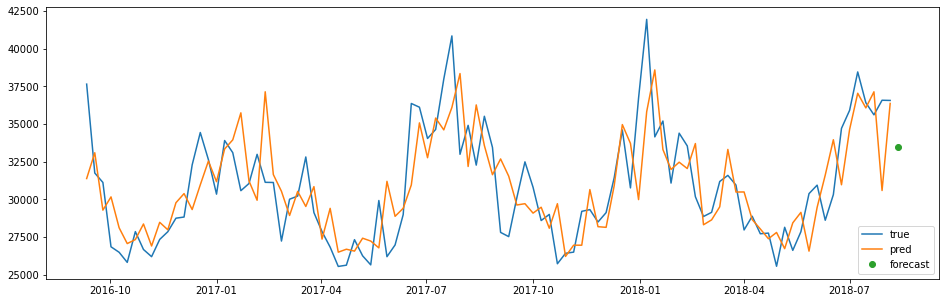

In [11]:
N = 100
plt.figure(figsize=(16,5))
plt.plot(df_pjme_mw_week['PJME_MW'][-N:], label='true')
plt.plot(result.predict()[-N:], label='pred')
plt.plot(result.forecast(), 'o', label='forecast')

plt.legend(loc='lower right')
plt.show()

- ACF у месячной модели выглядиит более резко.
- Месячная модель строится гораздо быстрее, что позволяет больше внимания уделить настройкам.
- Из недельной модели приходилось брать выборку для ускорения обучения.
- Предсказанные значения у месячной модели выглядят точнее - вероятно из-за обобщенности

## 4. Постройте ACF, PACF и модель ARIMA для BRENT (lнедельный )

In [12]:
df_brent = pd.read_csv('../input/ml-in-business/my_BRENT2019.csv', index_col=0, parse_dates=[0])
df_brent = reduction_memory(df_brent)
df_brent[:2]

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0


In [13]:
df_brent_week = df_brent.resample('W').mean()
df_brent_week[:2]

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-05,76.616000,2010.0,9.0,3.0,3.0,246.0,35.0,4.0,0.000000,0.2,0.000000
2010-09-12,77.673333,2010.0,9.0,8.5,3.0,251.5,36.0,2.5,0.166667,0.0,0.166667


In [14]:
# fill in empty value
get_oct = df_brent_week[(df_brent_week.index.year == 2011) & 
                        (df_brent_week.index.month == 10)]
df_brent_week.loc[df_brent_week['Значение'].isna(), 'Значение'] = get_oct['Значение'].mean()

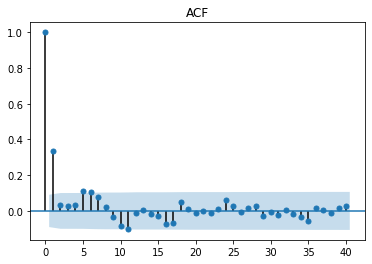

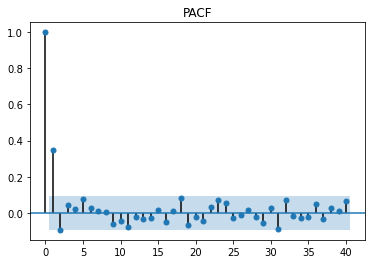

In [15]:
target = df_brent_week['Значение'].diff(1)[1:]

N = 40

#ACF
sm.graphics.tsa.plot_acf(target, lags=40, title='ACF')
plt.show()
#PACF
sm.graphics.tsa.plot_pacf(target.values[N:], lags=40, title='PACF')
plt.show()

                              ARMA Model Results                              
Dep. Variable:               Значение   No. Observations:                  469
Model:                     ARMA(1, 0)   Log Likelihood               -1016.979
Method:                       css-mle   S.D. of innovations              2.116
Date:                Fri, 06 Nov 2020   AIC                           2039.959
Time:                        12:00:53   BIC                           2052.411
Sample:                    09-12-2010   HQIC                          2044.858
                         - 09-01-2019                                         
============================================================================== ==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0358      0.146    

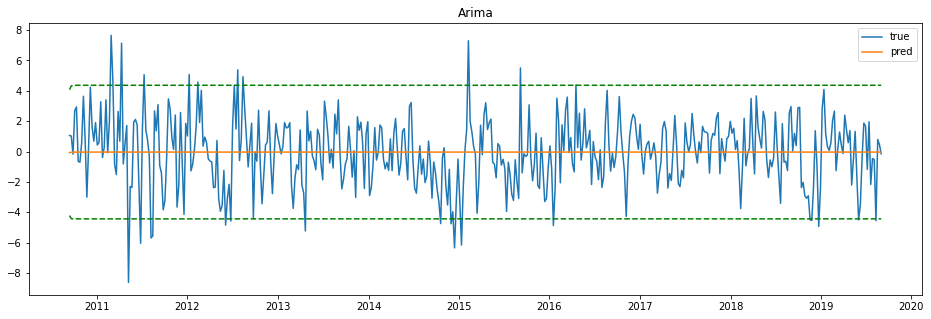

In [16]:
# ARIMA
model_arima = ARIMA(target, order=(1,0,0))
result = model_arima.fit(disp=False)

print(result.summary().tables[0], result.summary().tables[1])

y_p = result.predict(target.shape[0], target.shape[0], typ='levels')
y_f = result.forecast(target.shape[0])

plt.figure(figsize=(16,5))
plt.plot(target.index, target, label='true')
plt.plot(target.index, y_f[0], label='pred')
plt.plot(target.index, y_f[2], '--g')

plt.title('Arima')
plt.legend()
plt.show()

## 5. Оцените результат моделирования

ACF - показывает высокую кореляцию значений ряда<br>
ARIMA - показывает слишком обобщенный результат, из-за хаотичности данных

## 6. Сделайте предположение о моделях, которые лучше работают с техниками регрессии на основе AR I MA.

С ARIMA должны лучше работать стационарные модели, циклические, и трендовые - так как они омеют более-менее стабильную форму, которую модель может обобщить.<br>
Нестабильные модели обобщаются слишком сильно, что мешает ARIMA отследить зависимость в данных.